# Republican or Democrat Tweet Predictor

This notebook outputs a Stocastic Gradient Decent model for predicting the pollitical party of a tweeter.  Specifically, it outputs the following files:


In [57]:
import pandas as pd

# Tools to remove stopwords from tweets
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package stopwords to C:\Users\Herman D
[nltk_data]     Schaumburg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Herman D
[nltk_data]     Schaumburg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [58]:
stop_words = set(stopwords.words('english'))

def fix_party_code(pc):
    if pc == 100:
        return 'D'
    else:
        return 'R'
#    return int(pc/100-1)
def list_tostring(input_list):
    return ' '.join(input_list)

def remove_stopwords(input_list):
    return [w for w in input_list if not w in stop_words]

def clean_tweets(input_df):
    input_df['party_code'] = input_df['party_code'].apply(fix_party_code)
    input_df['text'] = input_df['text'].apply(word_tokenize)
    input_df['text'] = input_df['text'].apply(remove_stopwords)
    input_df['text'] = input_df['text'].apply(list_tostring)    
    return input_df

In [59]:
party_code_df = pd.read_csv("partycode.csv")
party_code_df.head()

,account_id,bioguide_id,mem_name,screen_name,chamber,state_abbr,party_code
0,37007274,Y000033,Don Young,repdonyoung,House,AK,200
1,2559398984,Y000033,Don Young,DonYoungAK,House,AK,200
2,2253968388,B001289,Bradley Byrne,RepByrne,House,AL,200
3,42481696,B001289,Bradley Byrne,BradleyByrne,House,AL,200
4,2861616083,P000609,Gary Palmer,USRepGaryPalmer,House,AL,200


In [60]:
party_dict = party_code_df[['party_code','account_id']].set_index('account_id').to_dict()
party_dict = party_dict['party_code']

In [61]:
# Specify dates for training data
dates = pd.date_range(start='4/10/2020', end='4/30/2020')
dates = [str(date)[0:10] for date in dates]

# Specify number of samples per day per party
date_samples = 1000
# date_samples = 200
print('Training data consists of '+str(date_samples*0.75*len(dates))+' tweets.')

Training day consists of 15750.0 tweets.


In [62]:
# Create empty dataframe
train_df = pd.DataFrame(columns=['text','party_code'])

for date in dates:
    date_str = date
    print(date)
    example_tweets = pd.read_json("mediabias_main/congresstweets/data/"+date_str+".json")
    example_tweets["party_code"] = example_tweets["user_id"]
    example_tweets = example_tweets.replace({"party_code":party_dict})
    date_train_data = example_tweets[(example_tweets['party_code']!=100)|(example_tweets['party_code']!=200)][['text','party_code']]
    # Rearrange rows
    date_train_data = date_train_data.sample(frac=1)
    date_train_data_R=date_train_data[date_train_data['party_code']==200].head(date_samples)
    date_train_data_D=date_train_data[date_train_data['party_code']==100].head(date_samples)
    # Remove stop words and fix party code
    date_train_data = clean_tweets(date_train_data_D.append(date_train_data_R, ignore_index=True))
    #if date == date[0]:
    #    train_df = date_train_data
    #else:
    train_df = train_df.append(date_train_data)#, ignore_index=True)

2020-04-10
2020-04-11
2020-04-12
2020-04-13
2020-04-14
2020-04-15
2020-04-16
2020-04-17
2020-04-18
2020-04-19
2020-04-20
2020-04-21
2020-04-22
2020-04-23
2020-04-24
2020-04-25
2020-04-26
2020-04-27
2020-04-28
2020-04-29
2020-04-30


In [63]:
train_df = train_df.reset_index(drop=True)

# Text Vectorization

In [64]:
from os import system
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from joblib import dump, load # used for saving and loading sklearn objects
from scipy.sparse import save_npz, load_npz # used for saving and loading sparse matrices

In [65]:
system("mkdir data_preprocessors")
system("mkdir vectorized_data")

# Unigram Counts
unigram_vectorizer = CountVectorizer(ngram_range=(1, 1))
unigram_vectorizer.fit(train_df['text'].values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [66]:
dump(unigram_vectorizer, 'data_preprocessors/unigram_vectorizer.joblib')

['data_preprocessors/unigram_vectorizer.joblib']

In [67]:
# unigram_vectorizer = load('data_preprocessors/unigram_vectorizer.joblib')

X_train_unigram = unigram_vectorizer.transform(train_df['text'].values)
save_npz('vectorized_data/X_train_unigram.npz', X_train_unigram)

In [68]:
# Unigram Tf-Idf

unigram_tf_idf_transformer = TfidfTransformer()
unigram_tf_idf_transformer.fit(X_train_unigram)

dump(unigram_tf_idf_transformer, 'data_preprocessors/unigram_tf_idf_transformer.joblib')

['data_preprocessors/unigram_tf_idf_transformer.joblib']

In [69]:
X_train_unigram_tf_idf = unigram_tf_idf_transformer.transform(X_train_unigram)

save_npz('vectorized_data/X_train_unigram_tf_idf.npz', X_train_unigram_tf_idf)

In [70]:
# Bigram Counts

bigram_vectorizer = CountVectorizer(ngram_range=(1, 2))
bigram_vectorizer.fit(train_df['text'].values)

dump(bigram_vectorizer, 'data_preprocessors/bigram_vectorizer.joblib')

['data_preprocessors/bigram_vectorizer.joblib']

In [71]:
X_train_bigram = bigram_vectorizer.transform(train_df['text'].values)

save_npz('vectorized_data/X_train_bigram.npz', X_train_bigram)

In [72]:
bigram_tf_idf_transformer = TfidfTransformer()
bigram_tf_idf_transformer.fit(X_train_bigram)

dump(bigram_tf_idf_transformer, 'data_preprocessors/bigram_tf_idf_transformer.joblib')

['data_preprocessors/bigram_tf_idf_transformer.joblib']

In [73]:
X_train_bigram_tf_idf = bigram_tf_idf_transformer.transform(X_train_bigram)

save_npz('vectorized_data/X_train_bigram_tf_idf.npz', X_train_bigram_tf_idf)

# SGDClassifier

In [74]:
def train_and_show_scores(X: csr_matrix, y: np.array, title: str) -> None:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, train_size=0.75, stratify=y
    )

    clf = SGDClassifier()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    valid_score = clf.score(X_valid, y_valid)
    print(f'{title}\nTrain score: {round(train_score, 2)} ; Validation score: {round(valid_score, 2)}\n')

y_train = train_df['party_code'].values

In [75]:
train_and_show_scores(X_train_unigram, y_train, 'Unigram Counts')
train_and_show_scores(X_train_unigram_tf_idf, y_train, 'Unigram Tf-Idf')
train_and_show_scores(X_train_bigram, y_train, 'Bigram Counts')
train_and_show_scores(X_train_bigram_tf_idf, y_train, 'Bigram Tf-Idf')

Unigram Counts
Train score: 0.98 ; Validation score: 0.85

Unigram Tf-Idf
Train score: 0.91 ; Validation score: 0.84

Bigram Counts
Train score: 1.0 ; Validation score: 0.85

Bigram Tf-Idf
Train score: 0.94 ; Validation score: 0.83



# Using Cross-Validation for hyperparameter tuning

In [76]:

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

X_train = X_train_bigram_tf_idf


# Phase 1: loss, learning rate and initial learning rate

clf = SGDClassifier()

distributions = dict(
    loss=['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    learning_rate=['optimal', 'invscaling', 'adaptive'],
    eta0=uniform(loc=1e-7, scale=1e-2)
)

random_search_cv = RandomizedSearchCV(
    estimator=clf,
    param_distributions=distributions,
    cv=5,
    n_iter=50
)
random_search_cv.fit(X_train, y_train)
print(f'Best params: {random_search_cv.best_params_}')
print(f'Best score: {random_search_cv.best_score_}')

Best params: {'eta0': 0.0027730188375447097, 'learning_rate': 'optimal', 'loss': 'modified_huber'}
Best score: 0.8307056312216291


In [77]:
# Phase 2: penalty and alpha

clf = SGDClassifier()

distributions = dict(
    penalty=['l1', 'l2', 'elasticnet'],
    alpha=uniform(loc=1e-6, scale=1e-4)
)

random_search_cv = RandomizedSearchCV(
    estimator=clf,
    param_distributions=distributions,
    cv=5,
    n_iter=50
)
random_search_cv.fit(X_train, y_train)
print(f'Best params: {random_search_cv.best_params_}')
print(f'Best score: {random_search_cv.best_score_}')

Best params: {'alpha': 8.22563552077361e-06, 'penalty': 'l2'}
Best score: 0.8417513684983096


## Saving best classifier

In [78]:
system("mkdir classifiers")

sgd_classifier = random_search_cv.best_estimator_

dump(random_search_cv.best_estimator_, 'classifiers/sgd_classifier.joblib')

# sgd_classifier = load('classifiers/sgd_classifier.joblib')

['classifiers/sgd_classifier.joblib']

# Testing Classifier

In [79]:
# Gather test data
# Create empty dataframe
test_df = pd.DataFrame(columns=['text','party_code'])

# Specify dates for test data
test_dates = pd.date_range(start='4/29/2020', end='5/3/2020')
test_dates = [str(date)[0:10] for date in dates]

for date in test_dates:
    date_str = date
    example_tweets = pd.read_json("mediabias_main/congresstweets/data/"+date_str+".json")
    example_tweets["party_code"] = example_tweets["user_id"]
    example_tweets = example_tweets.replace({"party_code":party_dict})
    date_test_data = example_tweets[(example_tweets['party_code']!=100)|(example_tweets['party_code']!=200)][['text','party_code']]
    date_test_data = clean_tweets(date_test_data)
    #if date == date[0]:
    #    train_df = date_train_data
    #else:
    test_df = test_df.append(date_test_data)#, ignore_index=True)
test_df = test_df.reset_index(drop=True)

In [80]:
X_test = bigram_vectorizer.transform(test_df['text'].values)
X_test = bigram_tf_idf_transformer.transform(X_test)
#X_test = unigram_tf_idf_transformer.transform(X_test)
y_test = test_df['party_code'].values

score = sgd_classifier.score(X_test, y_test)
print(score)

0.8482770444025373


In [82]:
test_df.shape

(64163, 3)

In [83]:
test_df['prediction'] = test_df['text']
def predict_out(thing):
    input = bigram_tf_idf_transformer.transform(bigram_vectorizer.transform([thing]))
    return sgd_classifier.predict(input)[0]
test_df['prediction'] = test_df['prediction'].apply(predict_out)
#test_df['decision'] = test_df['vectorize'].apply(sgd_classifier.decision_function)

In [85]:
test_df['decision'] = test_df['text']
def the_decision(thing):
    input = bigram_tf_idf_transformer.transform(bigram_vectorizer.transform([thing]))
    return sgd_classifier.decision_function(input)[0]
test_df['decision'] = test_df['decision'].apply(the_decision)

In [105]:
print(X_test[0])

  (0, 599005)	0.13724572483536815
  (0, 598951)	0.10656565688654346
  (0, 597099)	0.07127021892848737
  (0, 596894)	0.0696688776808445
  (0, 596846)	0.0835728977646812
  (0, 596744)	0.07270567427770662
  (0, 581647)	0.08857473689547032
  (0, 581646)	0.08857473689547032
  (0, 568348)	0.21930758305074324
  (0, 568331)	0.1444337225102922
  (0, 548752)	0.08863406696726873
  (0, 548751)	0.07262509899905804
  (0, 540410)	0.15026869719824917
  (0, 490821)	0.17796019880163338
  (0, 490349)	0.04953890780620524
  (0, 463264)	0.13594021526684116
  (0, 453481)	0.08854354953393861
  (0, 453480)	0.08889479295455144
  (0, 453479)	0.17708709906787723
  (0, 428661)	0.04428736844773516
  (0, 428648)	0.044257304066997766
  (0, 416758)	0.11230604339049131
  (0, 393887)	0.1256770018906141
  (0, 393424)	0.06886368196981775
  (0, 386663)	0.07274918547976898
  :	:
  (0, 284465)	0.06845672589731193
  (0, 279073)	0.1042605659520567
  (0, 270090)	0.197403356517461
  (0, 269808)	0.06095779986186125
  (0, 264594)	

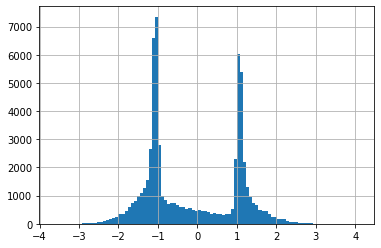

In [87]:
ax = test_df['decision'].hist(bins=100)  # s is an instance of Series
fig = ax.get_figure()
fig.savefig('histogram.svg')
fig.savefig('histogram.png')

In [88]:
from scipy import stats
import numpy as np

In [89]:
k2, p = stats.normaltest(test_df['decision'].tolist())
# a = np.random.normal(0, 1, size=100000)
# k2, p = stats.normaltest(a)

In [90]:
alpha = 5e-2

In [91]:
print("p = {:g}".format(p))

p = 0


In [92]:
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

The null hypothesis can be rejected


In [93]:
error_df = test_df[test_df['prediction']!=test_df['party_code']]
error_df['decision']=error_df['decision'].apply(abs)
error_df

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,text,party_code,prediction,decision
14,RT @ abbybroyles Today I filed run US Senate m...,D,R,0.573631
26,Coronavirus leading cause death US . If still ...,D,R,0.064032
27,@ MowliidAHassan @ DrTedros @ WHO It important...,D,R,0.474074
65,Mike Field dedicated life others . He EMT scen...,D,R,0.015497
78,RT @ CDCgov Wearing cloth face covering CORREC...,R,D,1.130982
...,...,...,...,...
64144,RT @ TorunnSinclair . @ christyforCA25 n't rec...,R,D,0.169626
64145,RT @ TorunnSinclair There PUBLIC RECORDS Newha...,R,D,0.815755
64148,Did Gov . Ducey make mistake opening state inc...,R,D,0.003236
64152,RT @ HispanicCaucus . @ HispanicCaucus Demands...,R,D,1.173668


In [94]:
total_errors = len(error_df)
print(f'total errors: {total_errors}')
print(f'accuracy/score check: {(len(test_df)-total_errors)/len(test_df)}')
num_data_points = 100
x_min = error_df['decision'].min()
x_max = error_df['decision'].max()
del_diff = (x_max - x_min)/num_data_points
x_data = [x_min+del_diff*j for j in range(0,num_data_points)]
y_data = [len(error_df[error_df['decision']>=x_data[j]])/total_errors
          for j in range(0,num_data_points)]

total errors: 9735
accuracy/score check: 0.8482770444025373


In [95]:
print(x_data)
print(y_data)

[3.70016628986336e-05, 0.032466992907313155, 0.06489698415172768, 0.0973269753961422, 0.12975696664055672, 0.16218695788497126, 0.19461694912938576, 0.22704694037380027, 0.25947693161821483, 0.2919069228626293, 0.3243369141070439, 0.3567669053514584, 0.38919689659587287, 0.42162688784028746, 0.45405687908470194, 0.4864868703291164, 0.518916861573531, 0.5513468528179455, 0.5837768440623601, 0.6162068353067746, 0.6486368265511891, 0.6810668177956036, 0.7134968090400181, 0.7459268002844327, 0.7783567915288472, 0.8107867827732617, 0.8432167740176763, 0.8756467652620907, 0.9080767565065052, 0.9405067477509198, 0.9729367389953343, 1.0053667302397487, 1.0377967214841632, 1.0702267127285778, 1.1026567039729922, 1.1350866952174068, 1.1675166864618214, 1.1999466777062358, 1.2323766689506503, 1.264806660195065, 1.2972366514394795, 1.329666642683894, 1.3620966339283085, 1.394526625172723, 1.4269566164171374, 1.459386607661552, 1.4918165989059666, 1.524246590150381, 1.5566765813947956, 1.5891065726

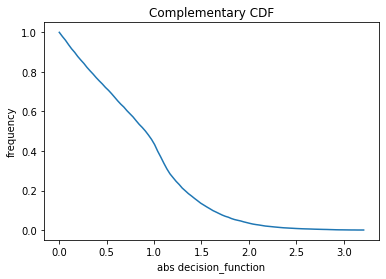

In [96]:
import matplotlib.pyplot as plt
plt.plot(x_data,y_data)
plt.ylabel('frequency')
plt.xlabel('abs decision_function')
plt.title('Complementary CDF')
plt.savefig('complementary_cdf.png')
plt.savefig('complementary_cdf.svg')
plt.show()


In [97]:
x_data[0]
x_data[len(x_data)-1]

3.2106061348599364

In [98]:
def get_accuracy(input_dec,cdf_x,cdf_y):
    y_len_minus_two = len(cdf_y)-2
    abs_input_dec = abs(input_dec)
    if abs_input_dec <= cdf_x[0]:
        return 'highly unreliable'
    elif abs_input_dec >= cdf_x[len(x_data)-1]:
        return 'highly reliable'
    else:
        j = 0
        while (abs_input_dec>=cdf_x[j])&(j<y_len_minus_two):
            j=j+1
        return 'estimated probability of error:'+str(cdf_y[j])+'.'

In [99]:
# Mitch McConnell
in_text = "This new bill strengthens some of the most important parts of the CARES Act, especially the popular Paycheck Protection Program which is saving millions of American jobs as we speak. And Republicans successfully kept extraneous issues out of the bill. It’s a win for the country."
fun_input = list_tostring(word_tokenize(in_text))
unigram_vectorizer = load('data_preprocessors/unigram_vectorizer.joblib')
X_pred = bigram_vectorizer.transform([fun_input])
X_pred = bigram_tf_idf_transformer.transform(X_pred)
sgd_classifier = load('classifiers/sgd_classifier.joblib')

result = sgd_classifier.predict(X_pred)
result[0]

'R'

In [100]:
dec = sgd_classifier.decision_function(X_pred)
dec
get_accuracy(dec,x_data,y_data)

'estimated probability of error:0.6535182331792502.'

In [101]:
# Chuck Schumer
in_text = "Amid coronavirus—Trump admin's actively working to roll back critical protections against predatory lenders We’ll fight this—we need to crack down on loan sharks preying on the most vulnerable consumers Not let them peddle interest rates as high as 800%!"
fun_input = list_tostring(word_tokenize(in_text))
unigram_vectorizer = load('data_preprocessors/unigram_vectorizer.joblib')
X_pred = bigram_vectorizer.transform([fun_input])
X_pred = bigram_tf_idf_transformer.transform(X_pred)
sgd_classifier = load('classifiers/sgd_classifier.joblib')

result = sgd_classifier.predict(X_pred)
result[0]

'D'

In [102]:
dec = sgd_classifier.decision_function(X_pred)
dec
print(dec)
get_accuracy(dec,x_data,y_data)

[-1.2618172]


'estimated probability of error:0.23030303030303031.'

In [103]:
print(get_accuracy(0.42,x_data,y_data))

estimated probability of error:0.7544940934771444.
